##### Разработка и валидация моделей

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import optuna
from statsmodels.tsa.arima.model import ARIMA


In [112]:
train_df = pd.read_parquet('train_df.parquet')
test_df = pd.read_parquet('test_df.parquet')

print(train_df.index.dtype)
train_df.head(3)

datetime64[ns]


,5,6,7,8,9,10,12,13,14,target,lag_1,lag_2,lag_3,lag_4,lag_5
date,,,,,,,,,,,,,,,
2023-06-16 05:30:00,2.486214,-0.935599,7.315273,-0.587990,0.004356,0.577218,0.404344,0.100478,1.379641,0.770,0.714,0.868,0.567,0.749,0.623
2023-06-16 08:30:00,2.476438,-0.934952,7.512617,-0.497816,0.004092,-0.452125,0.361782,0.106009,1.379641,0.770,0.770,0.714,0.868,0.567,0.749
2023-06-16 12:30:00,2.726013,-0.932443,7.441873,-0.844556,0.002917,-0.086983,0.438926,0.118177,1.379641,0.609,0.770,0.770,0.714,0.868,0.567


In [ ]:
print(train_df.columns,
      '\n',
      test_df.columns)
test_df = test_df.rename(columns={5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 12: '12', 13: '13', 14: '14'})

Index(['5', '6', '7', '8', '9', '10', '12', '13', '14', 'target', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object') 
 Index([5, 6, 7, 8, 9, 10, 12, 13, 14], dtype='object')
Index(['5', '6', '7', '8', '9', '10', '12', '13', '14', 'target', 'lag_1',
       'lag_2', 'lag_3', 'lag_4', 'lag_5'],
      dtype='object') 
 Index(['5', '6', '7', '8', '9', '10', '12', '13', '14'], dtype='object')


##### XGBoost

Fold 1: RMSE = 0.1548, R² = 0.0421
Fold 2: RMSE = 0.1209, R² = -0.4110
Fold 3: RMSE = 0.1383, R² = -0.0164
Fold 4: RMSE = 0.1246, R² = 0.0798
Fold 5: RMSE = 0.1795, R² = 0.1921
Mean RMSE: 0.1436
Mean R²: -0.0227


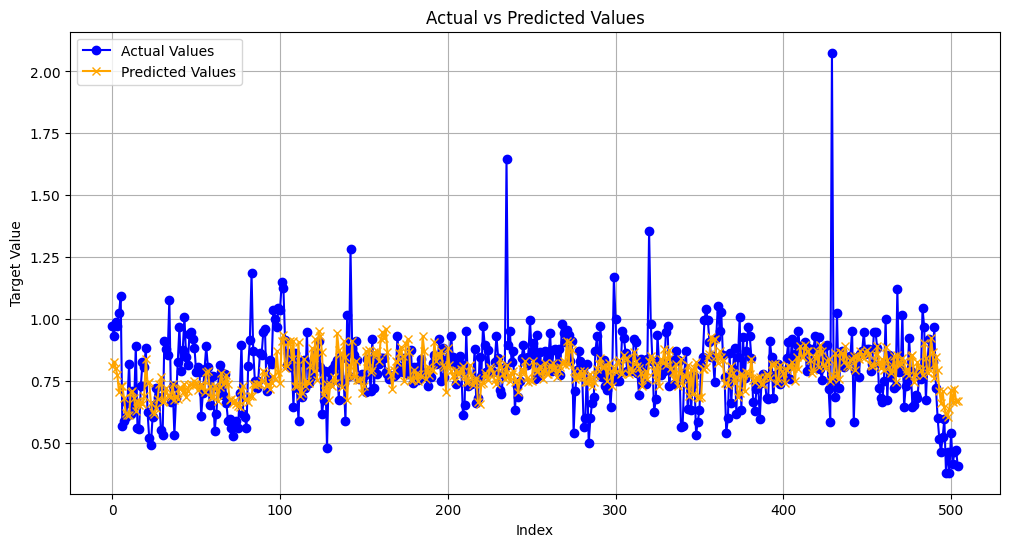

In [114]:
y = train_df['target']
X = train_df.drop(columns=['target'])

r2_scores = []
rmse_scores = []
predictions = []
actuals = []

tscv = TimeSeriesSplit(n_splits=5)

for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train, X_test = X.values[train_index], X.values[test_index]
    y_train, y_test = y.values[train_index], y.values[test_index]
    
    model = XGBRegressor(objective='reg:squarederror', 
                         alpha=0.7301647364174587, 
                         learning_rate=0.08531620322319103, 
                         n_estimators=326)  

    model.fit(X_train, y_train)

    preds = model.predict(X_test)

    rmse = np.sqrt(mean_squared_error(y_test, preds))
    r2 = r2_score(y_test, preds)
    
    rmse_scores.append(rmse)
    r2_scores.append(r2)
    
    predictions.extend(preds)
    actuals.extend(y_test)
    
    print(f"Fold {i + 1}: RMSE = {rmse:.4f}, R² = {r2:.4f}")

mean_rmse = np.mean(rmse_scores)
mean_r2 = np.mean(r2_scores)

print(f"Mean RMSE: {mean_rmse:.4f}")
print(f"Mean R²: {mean_r2:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Values', color='blue', marker='o')
plt.plot(predictions, label='Predicted Values', color='orange', marker='x')
plt.title('Actual vs Predicted Values')
plt.xlabel('Index')
plt.ylabel('Target Value')
plt.legend()
plt.grid()
plt.show()


In [ ]:
last_five_values = train_df['target'][-5:].values
lagged_df = pd.DataFrame(data=[last_five_values], columns=['lag_' + str(lag) for lag in range(5, 0, -1)])
predictions_oot = []

for i in range(len(test_df)):
    test_df_n = test_df.iloc[[0]]
    lagged_df.index = [0]
    test_df_n.index = [0]
    pred = pd.concat([test_df_n, lagged_df], axis=1)
    prediction = model.predict(pred)
    lagged_df = lagged_df.drop(columns=['lag_5'])
    lagged_df = lagged_df.rename(columns={'lag_4': 'lag_5', 'lag_3': 'lag_4', 'lag_2':'lag_3', 'lag_1': 'lag_2'})
    lagged_df['lag_1'] = [prediction][0]
    predictions_oot.extend(prediction)
    
results = pd.DataFrame({
    'Date': test_df.index, 
    'Predictions': predictions_oot 
})

results.to_csv('predictions-xgboost.csv') 

results


,Date,Predictions
0,2023-09-02 20:30:00,0.632758
1,2023-09-03 00:30:00,0.628241
2,2023-09-03 03:30:00,0.646803
3,2023-09-03 05:30:00,0.610408
4,2023-09-03 08:30:00,0.597076
...,...,...
149,2023-09-21 20:30:00,0.608202
150,2023-09-22 00:30:00,0.608202
151,2023-09-22 03:30:00,0.608202
152,2023-09-22 05:30:00,0.608202


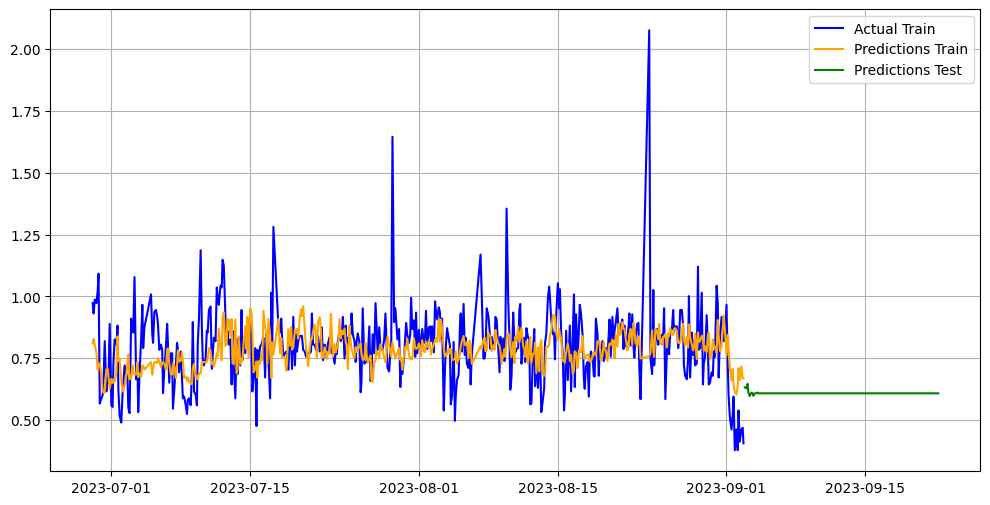

In [119]:
time_predictions = train_df.index[103:]
time_predictions_oot = test_df.index

plt.figure(figsize=(12, 6))

plt.plot(time_predictions, actuals, label='Actual Train', color='blue')
plt.plot(time_predictions, predictions, label='Predictions Train', color='orange')

plt.plot(time_predictions_oot, predictions_oot, label='Predictions Test', color='green')

plt.legend()
plt.grid()

plt.show()

In [ ]:

# y = train_df['target']
# X = train_df.drop(columns=['target'])

# def objective(trial):
#     alpha = trial.suggest_float('alpha', 0, 1) 
#     learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3)  
#     n_estimators = trial.suggest_int('n_estimators', 50, 500)  

#     rmse_scores = []
#     r2_scores = []

#     tscv = TimeSeriesSplit(n_splits=5)

#     for train_index, test_index in tscv.split(X):
#         X_train, X_test = X.values[train_index], X.values[test_index]
#         y_train, y_test = y.values[train_index], y.values[test_index]

#         model = XGBRegressor(objective='reg:squarederror', 
#                               alpha=alpha, 
#                               learning_rate=learning_rate, 
#                               n_estimators=n_estimators)
#         model.fit(X_train, y_train)
#         preds = model.predict(X_test)

#         rmse = np.sqrt(mean_squared_error(y_test, preds))
#         r2 = r2_score(y_test, preds)
        
#         rmse_scores.append(rmse)
#         r2_scores.append(r2)

#     return np.mean(rmse_scores)

# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=100)

# print("Best hyperparameters: ", study.best_params)
# print("Best RMSE: ", study.best_value)

# joblib.dump(model, 'xgb_model.pkl')

['xgb_model.pkl']

#### ARIMA

[I 2025-07-09 13:25:22,370] A new study created in memory with name: no-name-7f7542f7-00b8-4805-899d-45e4e51bfcc8


/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood opti

Best parameters: {'p': 4, 'd': 0, 'q': 4}
Test RMSE: 0.12840909557914182
Test R²: 0.309429958475829


/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/krasarma/miniconda3/envs/polus-prepare/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


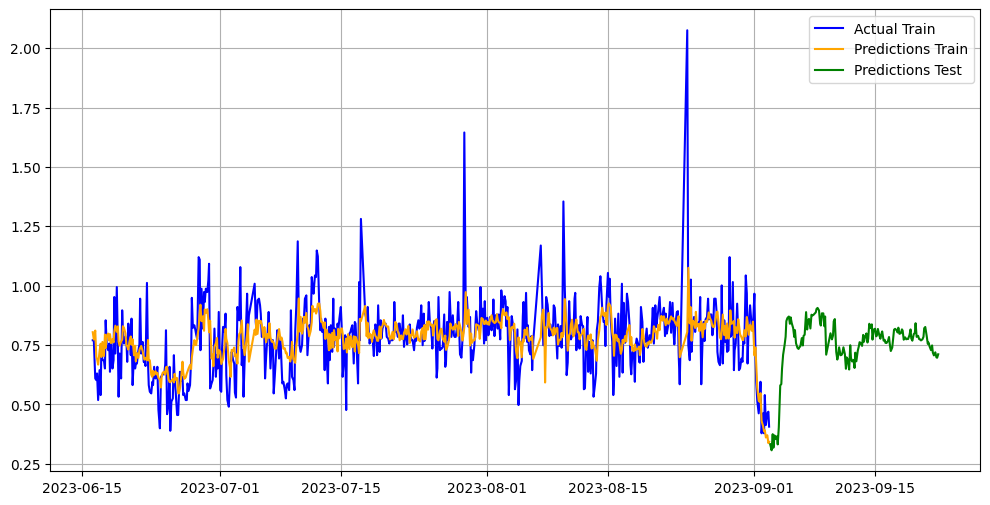

In [ ]:
test_df = test_df.rename(columns={5: '5', 6: '6', 7: '7', 8: '8', 9: '9', 10: '10', 12: '12', 13: '13', 14: '14'})

train_df.index = pd.to_datetime(train_df.index)
test_df.index = pd.to_datetime(test_df.index)

exog_train = train_df[['5', '6', '7', '8', '9', '10', '12', '13', '14']]
exog_test = test_df[['5', '6', '7', '8', '9', '10', '12', '13', '14']]

def evaluate_model(trial):
    p = trial.suggest_int('p', 0, 5)
    d = trial.suggest_int('d', 0, 2)
    q = trial.suggest_int('q', 0, 5)

    model = ARIMA(train_df['target'], order=(p, d, q), exog=exog_train)
    model_fit = model.fit()  

    predictions = model_fit.predict(start=0, end=len(train_df) - 1, exog=exog_train)
    rmse = np.sqrt(mean_squared_error(train_df['target'], predictions))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(evaluate_model, n_trials=50)

best_params = study.best_params
print("Best parameters:", best_params)

model = ARIMA(train_df['target'], order=(best_params['p'], best_params['d'], best_params['q']), exog=exog_train)
model_fit = model.fit() 

predictions = model_fit.predict(start=0, end=len(train_df) - 1, exog=exog_train)
predictions_oot = model_fit.predict(start=len(train_df), end=len(train_df) + len(test_df) - 1, exog=exog_test)


rmse = np.sqrt(mean_squared_error(train_df['target'], predictions))
r2 = r2_score(train_df['target'], predictions)

print("RMSE:", rmse)
print("R²:", r2)

plt.figure(figsize=(12, 6))
plt.plot(train_df.index, train_df['target'], label='Actual Train', color='blue')
plt.plot(train_df.index, predictions, label='Predictions Train', color='orange')
plt.plot(test_df.index, predictions_oot, label='Predictions Test', color='green')
plt.legend()
plt.grid()
plt.show()


In [133]:
joblib.dump(model_fit, 'arima_model.pkl')

results = pd.DataFrame({
    'Date': test_df.index, 
    'Predictions': predictions_oot 
})

results.to_csv('predictions-arima.csv') 

results

,Date,Predictions
608,2023-09-02 20:30:00,0.358118
609,2023-09-03 00:30:00,0.336348
610,2023-09-03 03:30:00,0.358108
611,2023-09-03 05:30:00,0.328701
612,2023-09-03 08:30:00,0.360827
...,...,...
757,2023-09-21 20:30:00,0.712290
758,2023-09-22 00:30:00,0.726798
759,2023-09-22 03:30:00,0.706667
760,2023-09-22 05:30:00,0.707319
